In [1]:
from google.colab import files

uploaded = files.upload()

Saving kaggle.json to kaggle (3).json


In [2]:
# ! pip install kaggle

In [2]:
! mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [3]:
! cp kaggle.json ~/.kaggle/

In [4]:
! chmod 600 ~/.kaggle/kaggle.json

In [5]:
! kaggle datasets download -d shmalex/instagram-dataset -f instagram_locations.csv
! kaggle datasets download -d shmalex/instagram-dataset -f instagram_posts.csv
! kaggle datasets download -d shmalex/instagram-dataset -f instagram_profiles.csv

instagram_locations.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
instagram_posts.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
instagram_profiles.csv.zip: Skipping, found more recently modified local copy (use --force to force download)


In [6]:
! unzip instagram_locations.csv.zip
! unzip instagram_profiles.csv.zip
! unzip instagram_posts.csv.zip

Archive:  instagram_locations.csv.zip
replace instagram_locations.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: instagram_locations.csv  
Archive:  instagram_profiles.csv.zip
replace instagram_profiles.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: instagram_profiles.csv  
Archive:  instagram_posts.csv.zip
replace instagram_posts.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: instagram_posts.csv     


In [7]:
import pandas as pd
import scipy
import numpy as np
import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import random
from datetime import datetime

In [9]:
import pandas as pd
cols_locations = ['id', 'name', 'city']
cols_profiles = ['profile_id', 'followers', 'n_posts', 'profile_name']
cols_posts = ['profile_id', 'location_id', 'post_type', 'numbr_likes', 'number_comments', 'cts']
df_locations = pd.read_csv('instagram_locations.csv', sep='\t', usecols = cols_locations)   
df_profiles = pd.read_csv('instagram_profiles.csv', sep='\t', usecols = cols_profiles)        
df_posts = pd.read_csv('instagram_posts.csv', sep='\t', nrows=None, usecols=cols_posts)

### Plot the top 10 most popular users in terms of followers and their number of posts.

In [10]:
#extract top 10 ten users
top_10 = df_profiles.sort_values(by = 'followers', ascending=False).head(10)
top_10_profile_id = np.array(list(map(int, top_10['profile_id'].values)))
print(*df_profiles[df_profiles['profile_id'].isin(top_10_profile_id)]['profile_name'].values, sep = '\n' )

hm
louisvuitton
danbilzerian
akshaykumar
buzzfeedtasty
victoriassecret
andresiniesta8
instagram
nba
princessyahrini


Text(0, 0.5, 'Posts')

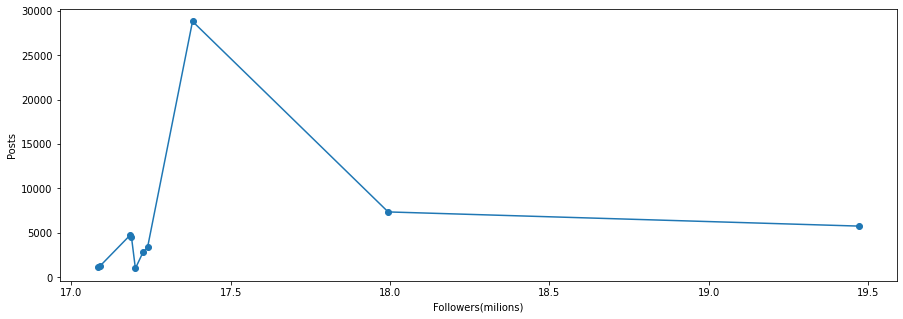

In [11]:
# we use the log to scale the x axis in order to make the plot more clear (there is a huge gap between the first three profiles and the other 7)
x = np.log(top_10['followers'].values)
y = top_10['n_posts'].values

plt.figure(figsize=(15,5))
plt.plot(x,y, 'o-')
plt.xlabel('Followers(milions)')
plt.ylabel('Posts')

Plot without the last two elements to better visualize the trend

Text(0, 0.5, 'Posts')

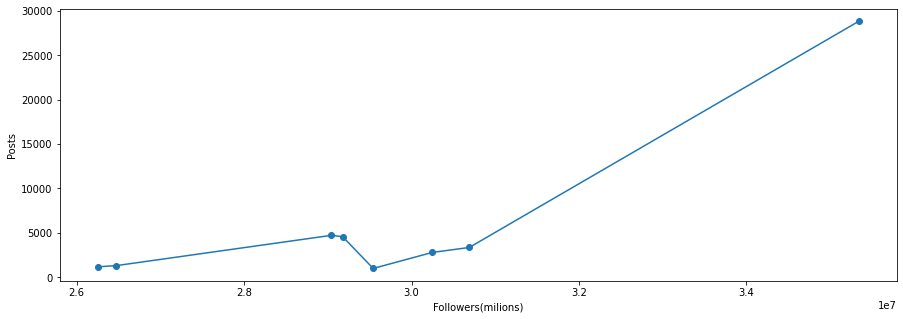

In [12]:
x = top_10['followers'].values[2:]
y = top_10['n_posts'].values[2:]

plt.figure(figsize=(15,5))
plt.plot(x,y, 'o-')
plt.xlabel('Followers(milions)')
plt.ylabel('Posts')

It seems that there is some correlation between followers and posts, at least for these top profiles. The more the followers the more the posts, however this is not always the case, because the number of posts is something strongly dependent on the type of profile.

### Who is the most influential user?

In [13]:
print(top_10.head(1)['profile_name'].values)

['instagram']


Not surprisingly the most influential user is... the instagram official account :)

### Have they posted anything with tagged locations? Extract the most frequent areas on their posts and plot the number of times each city has been visited.

In [14]:
# select all the locations in the posts of the top 10 users
top_10_locations = df_posts[df_posts['profile_id'].isin(top_10_profile_id)].values[:,1] # location id
# remove NaN
top_10_locations = top_10_locations[~pd.isnull(top_10_locations)] 

In [15]:
#extract frequences
areas_frequences = df_locations[df_locations['id'].isin(top_10_locations)]['name'].dropna().value_counts()
areas_frequences.head(10)

Victoria's Secret                                       4
InfoCision Stadium–Summa Field                          1
Long Chim Singapore                                     1
Hadleigh Park                                           1
Staten Island Boat Graveyard                            1
Brodie Castle                                           1
Hollywood United Methodist Church - Hollywood Campus    1
Exuma, The Bahamas                                      1
Universiteitstheater Amsterdam                          1
Beany Green Coffee                                      1
Name: name, dtype: int64

There is no particular frequent areas, as we can see all the places have frequence 1, except from Victoria's Secret, but this is due to the fact that one of the top 10 profile is indeed Victoria's Secret.

([0, 1, 2, 3, 4, 5, 6, 7], <a list of 8 Text major ticklabel objects>)

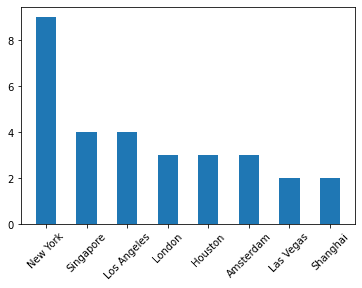

In [16]:
import re
top_10_cities = df_locations[df_locations['id'].isin(top_10_locations)]['city'].dropna()  # RISOLVERE PROBLEMA DELLA PERDITA 105 -> 92
cities = top_10_cities.value_counts().index
counts = top_10_cities.value_counts().values
cities = [re.match(r'^[\s\w]*', el).group(0) for el in cities]
#collapse cities with count=1 into 'others'
counts = counts[counts != 1]
#cities = cities[: len(counts)]
plt.bar(cities[: len(counts)], counts, width=0.5)
plt.xticks(rotation=45)

This are the most frequent cities. We see that New York is on top (as always). 
There are then other cities that show up in the posts but they appear just once, here's are a bunch of them:

In [17]:
print(*cities[len(counts):len(counts)+10], sep='\n')

Chawton
Xiandu
Kirkkonummi
Krian
Akron
McLean
Hadleigh
San Francisco
Memphis
Pôrto São José


How many pictures-only posts have they published? How many reels? (only videos) and how many with both contents? Provide the number as percentages and interpret those figures.

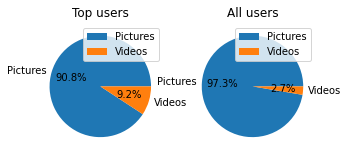

In [18]:
#top 10 users
df_posts_restricted = df_posts[df_posts['profile_id'].isin(top_10_profile_id)]
pic_vid_both_counts = df_posts_restricted['post_type'].value_counts()
display = pd.DataFrame({'': [pic_vid_both_counts.values[0], pic_vid_both_counts.values[1]]},index = ['Pictures','Videos'])
#display.plot.pie(y='', figsize=(5,5), title='Top users', autopct='%1.1f%%')
#all users
pic_vid_both_counts2 = df_posts['post_type'].value_counts()
display_all = pd.DataFrame({'': [pic_vid_both_counts2.values[0], pic_vid_both_counts2.values[1]]},index = ['Pictures','Videos'])
#display_all.plot.pie(y='', figsize=(5,5), title='Top users', autopct='%1.1f%%')

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,15))
display.plot.pie(y='', figsize=(10,10), title='Top users', autopct='%1.1f%%', ax=axes[0])
display_all.plot.pie(y='', figsize=(5,5), title='All users', autopct='%1.1f%%', ax=axes[1])



We omitted the post with both contents because it is 0% for Top users and 0.1% for All users. \\
As we can expect the vast majority of posts are pictures, and it's because pictures are easier to post, catchier and more visual impacting. 
There is a discrepancy though between top and all users, indeed top users tend to post more videos. This can be explained as follows: in the years the dataset was collected the reels were not a popular content type as pictures (today those percentages would be much less unbalanced) so it is evident that top users tend to experiment more on new features available on the platform than the average user.

In [19]:

pictures_posts = df_posts_restricted[df_posts_restricted['post_type'] == 1][['numbr_likes', 'number_comments']]
video_posts = df_posts_restricted[df_posts_restricted['post_type'] == 2][['numbr_likes', 'number_comments']]

display = pd.DataFrame({'' : ['pictures', 'videos'],
                       'likes':[int(pictures_posts['numbr_likes'].mean()), int(video_posts['numbr_likes'].mean())],
                       'comments':[int(pictures_posts['number_comments'].mean()), int(video_posts['number_comments'].mean())]})

display.head()

,,likes,comments
0,pictures,541294,3882
1,videos,266524,2019


It is clear that pictures are more appriciated by the community, as we said pictures have stronger visual impact than videos. \\
Let's compare now these numbers with the followers mean of these users.

In [20]:
print(int(df_profiles[df_profiles['profile_id'].isin(top_10_profile_id)]['followers'].mean()))

58749283


This is a very common thing on almost every platform on the web like Instagram, Facebook, Youtube ecc. Only a very small percentage of followers are actually active and give feedback to the profile contents.

What is the average time (days and minutes) a user lets pass before publishing another post? Plot the top 3 users that publish posts more frequently (calculate the average time that passes between posts), including their amount of followers and following. Provide insights from that chart.

[Text(0, 0, '00-03'),
 Text(0, 0, '03-05'),
 Text(0, 0, '05-11'),
 Text(0, 0, '11-14'),
 Text(0, 0, '14-17'),
 Text(0, 0, '17-20'),
 Text(0, 0, '20-00')]

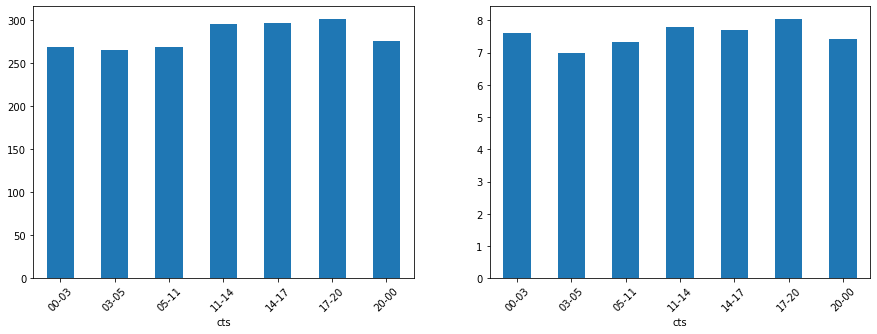

In [21]:
#we first
from datetime import datetime
beginning_of_the_day = datetime.strptime('00:00:00', '%H:%M:%S')
ranges = ['00:00:00' ,'02:59:59', '05:59:59', '10:59:59', '13:59:59', '16:59:59', '19:59:59', '23:59:59']
ranges = [(datetime.strptime(el, '%H:%M:%S') - beginning_of_the_day).total_seconds() for el in ranges]
frequences = df_posts.groupby(pd.cut(df_posts.cts.apply(lambda x: (datetime.strptime(x[11:], '%H:%M:%S.000') - 
                                                                   beginning_of_the_day).total_seconds() if isinstance(x, str) else x), ranges)).mean()
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
frequences['numbr_likes'].plot.bar(ax=axes[0], rot=45).set_xticklabels(['00-03','03-05','05-11','11-14','14-17','17-20','20-00'])
frequences['number_comments'].plot.bar(ax=axes[1], rot=45).set_xticklabels(['00-03','03-05','05-11','11-14','14-17','17-20','20-00'])

In [22]:
#convert date time into seconds for efficiency
from datetime import datetime
fmt = '%Y-%m-%d %H:%M:%S.000'
df_posts.dropna(inplace=True)
min_date = df_posts['cts'].min()
reference_date = datetime.strptime(min_date, fmt)
df_posts['cts'] = df_posts['cts'].apply(lambda x: (datetime.strptime(x, fmt) - reference_date).total_seconds())

In [23]:
# we observe that when computing the 
means = (df_posts.groupby(['profile_id']).max()['cts'] - 
         df_posts.groupby(['profile_id']).min()['cts'])/df_posts.groupby(['profile_id']).count()['numbr_likes'].apply(lambda x : x - 1 if x >= 2 else x) 
most_frequent_profile = means[means != 0].sort_values().head(3)
print(most_frequent_profile)

profile_id
1.127936e+07    0.333333
1.929792e+09    0.500000
8.920183e+09    0.500000
dtype: float64


The top three have a mean time less than 1 second which can be strange. If we see 

In [24]:
print(df_profiles[df_profiles['profile_id'].isin(most_frequent_profile.index)])

Empty DataFrame
Columns: [profile_id, profile_name, followers, n_posts]
Index: []


In [25]:
from datetime import timedelta
overall_mean = (df_posts.groupby(['profile_id']).max()['cts'] - df_posts.groupby(['profile_id']).min()['cts']).sum()/df_posts.groupby(['profile_id']).count()['location_id'].sum()
print(timedelta(overall_mean))

2413463 days, 1:39:26.052653


In [26]:
l = [42361942, 8128232, 222026992, 1518481370, 230617661, 355470702, 222580681, 273342922, 335637382, 232070804]
df_profiles[df_profiles['profile_id'].isin(l)]

,profile_id,profile_name,followers,n_posts
238134,232070804.0,cozeteg,389573.0,5761.0
1319263,222580681.0,beltenvy,432.0,490.0
2619235,335637382.0,ernestobarajasoficial,323186.0,2892.0
3841218,222026992.0,ekadarville,72170.0,419.0
4031324,8128232.0,melisaaugusto,957.0,1578.0


So on average the time that pass between two consecutive posts of the same user is 1 hour and 40 minutes.

# RQ7 #

## a) What's the probability that a post receives more than 20% "likes" of the number of followers a user has? ##

In [ ]:
import sys
sys.modules[__name__].__dict__.clear()

In [8]:
#del df_profiles
#del df_posts
#del df_locations
cols_profiles = ['profile_id', 'followers', 'n_posts', 'profile_name']
cols_posts = ['profile_id', 'location_id', 'numbr_likes', 'number_comments', 'cts']
df_profiles = pd.read_csv('instagram_profiles.csv', sep='\t', usecols = cols_profiles)        
df_posts = pd.read_csv('instagram_posts.csv', sep='\t', nrows=None, usecols=cols_posts)

In [9]:
data_profiles2 = df_profiles[['profile_id', 'followers']] # we selected only two columns from profiles that are profile_id
                                                            # and followers

In [10]:
data_profiles2 = data_profiles2.dropna(axis = 0, how = 'any') # we remove all the rows of the dataset that show a missing value
                                                              # of profile_id or followers

In [11]:
data_posts2 = df_posts[['profile_id', 'numbr_likes']]  # we selected only two columns from posts that are profile_id
                                                         # and numbr_likes

In [12]:
data_posts2 = data_posts2.dropna(axis = 0, how = 'any')  # we remove all the rows of the dataset that show a missing value
                                                         # of profile_id or numbr_likes

In [13]:
print(data_posts2.shape)
print(data_profiles2.shape)

(40126905, 2)
(3447698, 2)


In [14]:
merge = pd.merge(data_profiles2, data_posts2, on = "profile_id" )  # we do the merge between the two set on the variable profile_id
                                                                   # because we want to use only the profiles that have a match in both of dataset

In [15]:
prob = (merge['numbr_likes'].gt(merge['followers'].apply(lambda x: x*.2))).sum()/merge.shape[0]
print(prob)

0.15716325833178058


We calculated the number of posts that receives more than 0.20 % likes of the number of followers and we divided it by the total number of posts to get the probability

The probability is almost 0.1572 very low, but it makes sense because people, in general, have more followers than the number of likes of every post.

## b) Do users usually return to locations? Extract the probability that a user returns to a site after having posted it in the past. Does that probability make sense to you? Explain why or why not. ##

In [21]:
data_posts_loc = df_posts[['profile_id','location_id']].dropna(axis = 0, how = 'any')  
# # we selected only two columns from posts that are profile_id
# # and location_id


In [22]:
s = np.sum((df_posts[['profile_id','location_id']].dropna(axis = 0, how = 'any').groupby(['profile_id','location_id']).size() > 1))
# we calculated the occurrences of location that are repeated more than one for every profile that means count 1 every time a 
# profile publishes a post in a previously posted location.

KeyboardInterrupt: ignored

In [ ]:
prob2 = s/data_posts_loc.shape[0]
print(prob2)
del data_posts_loc

The probability is very low, it is almost 0.1035. I think that this probability doesn't make sense if we consider that a person, who inserted a location, wasn't necessarily in that location in reality. On instagram, people uses location also to obtain more visualizations and likes.

# RQ8 #



## a) Does more likes also mean more comments? ##

To see easily the relationship between likes and comments we compute two different sized random samples of data_posts to comply approximately the behaviour of the entire dataset. Obviously, bigger is the sample size, greater is the proximity to the entire dataset. To obtain a good visualization we use two reandom samples of size 50000 and 100000.

In [20]:
new_data = df_posts.sample(n = 50000, random_state = 10)
new_data2 = df_posts.sample(n = 100000, random_state = 10)

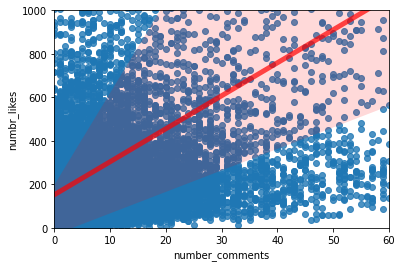

In [21]:
sns.regplot(x=new_data.number_comments, y=new_data.numbr_likes, line_kws={"color":"r","alpha":0.7,"lw":5})
plt.xlim(0,60)
plt.ylim(0,1000)
plt.show()

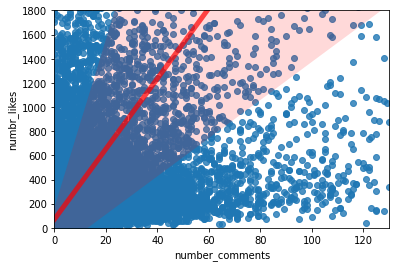

In [22]:
sns.regplot(x=new_data2.number_comments, y=new_data2.numbr_likes, line_kws={"color":"r","alpha":0.7,"lw":5})
plt.xlim(0,130)
plt.ylim(0,1800)
plt.show()

As said previously, to obtain a better visualization, we computed a random sample of size 10000 from the population. This sample must have the more or less the same characteristics of the total population. The scatterplot shows the relationship between the number of comments and the number of likes and, as can be seen, there is a positive relationship. To show the positive linear relationship even better, we have constructed a regression line. The line has a positive angular coefficient, which shows that as comments increase, on average, the number of likes also increases. We can also compute the index correlation to show numerically the intensity of this linear relationship, but we can do it directly on the entire dataset.


In [23]:
new_data.corr()

,profile_id,location_id,numbr_likes,number_comments
profile_id,1.000000,0.035482,-0.041830,-0.026470
location_id,0.035482,1.000000,0.008681,0.001180
numbr_likes,-0.041830,0.008681,1.000000,0.419304
number_comments,-0.026470,0.001180,0.419304,1.000000


This is the correlation matrix only for the columns of number of likes and number of comments. Correlation index measures the intensity of the lineare relationship and in this particular case there is a presence of a small positive linear relationship and it is equal to 0.374453. 

## b) Can you find any significant relationship between the time a user publishes a post and the number of comments and “likes”? Use an appropriate statistical test or technique and support your choice. ##

In [ ]:
data_posts_cts = df_posts[['numbr_likes','number_comments','cts']].dropna(axis = 0, how = 'any')  # if there are missing values we are dropping rows that contain them

In [ ]:
type(data_posts_cts.cts.values[0])   #the type of elements of cts column is string

In [ ]:
def convert(date):
    if isinstance(date,str):
        return pd.Timestamp(date).hour     # we creted a function that convert the strings in pandas data type
                                           # and we extracted only the hours to compute summaries that male sense on the time

In [ ]:
data_posts_cts['cts'] = data_posts_cts['cts'].apply(convert) # we apply the function on the entire column cts

Now, we want to make groups by hours and compute some statistic summaries of number of like and number of comment to understand the relationship of the time among these variables. 
First we calculate the average of likes and comments based on hours, so we can understand what is the best time to publish posts to get more likes or comments.

In [ ]:
mean_data_sorted_likes = data_posts_cts.groupby('cts').mean().sort_values(['numbr_likes','number_comments'], ascending  = False)

In [ ]:
mean_data_sorted_likes

We sorted the results by likes and comments and as shown the best time to publish a post is at 18 or 16. Usually the first hours of a post are the most important because in this time period the post has more visibility, for this reason it is relevant to follow this table.

In [ ]:
mean_data_sorted_comments = data_posts_cts.groupby('cts').mean().sort_values(['number_comments','numbr_likes'], ascending  = False)

In [ ]:
mean_data_sorted_comments

This time, we sorted the results by comments and then by likes and as shown the best time to publish a post is 18 too ( another confirm that it is the best time to publish a post) or 20. In both cases the worst hours to publish a post seems to be 5, 6 and 22.

## c) What’s the distribution of followers? Plot the empirical distribution of followers amongst all users and extract the mean, mode, and quantiles. Interpret those figures. ## 

In [ ]:
sns.ecdfplot(data_profiles2, 
             x="followers",)
plt.ylim(0,1.5)

This is the plot of the empirical distrubution of followers amongst all users. The fact that the probability 1 is reached "near" the value zero means that there are few values that are very big, most of the distribution doesn't have very high values of followers. We can also compute all the values of the cumulative distribution function with the following code.

In [ ]:
import dc_stat_think as dcst
from statistics import mode

In [ ]:
x, y = dcst.ecdf(data_profiles2.followers)

In [ ]:
plt.plot(x,y)
plt.xlim(0,50000)
plt.show()


We have the same result, but now we have a more concentrated visualization to see the behaviour of the function for lower values. Furthermore, we can use the  calculated values to extract the mean, mode and quantiles.

In [ ]:
average = np.mean(x)
print(average)


The mean of the followers of all users is about 4740. This value summarizes the entire distribution of followers with a single number representing the data’s center point or typical value.

In [ ]:
median = np.min(x[y >= 0.5])
print(median)


The median is equal to 406.0. This value is the midpoint of the distribution and is the point at which half the observations are above the value and half the observations are below the value. The median and the mean both measure central tendency. But unusual values, called outliers, can affect the median less than they affect the mean. In this case the distribution is positevely asymmetric because the mean is greater than the median. This could suggest that there are very large values of followers that affect the average, perhaps possible outliers, but if we think about the nature of the dataset concerning instagram, they they could only be famous people with a lot of followers.

In [ ]:
moda = mode(x)
print(moda)

The mode is 0.0, it the value that appears most frequently in a data set. This value makes it clear that there are a very high amount of profiles that have 0 followers. This low number could be due to the presence of many fake accounts or many bot accounts without followers.

In [ ]:
first_quantile = np.min(x[y >= 0.25])
print(first_quantile)

second_quantile = median
print(second_quantile)

third_quantile = np.min(x[y >= 0.75])
print(third_quantile)

The quantiles, more precisely the quartiles have an interpretation similar to that of the median. In this case the first quartile is 159.0 and it means that the 25% of profiles on instagram have less than 159 followers.

The second quartile is equal to the median and it means that a 50% of the profiles have less than 406 followers, but also that the other 50% of the profiles have more than 406 followers.

The third quartile is 974.0 and it means that the 25% of profiles on instagram have more than 974.0 followers or the 75% of profiles on instagram have less than 974.0 followers.

Thanks to these quartiles we can see how the average ranks beyond the third quartile, precisely because there are very high values of followers that influence it.

## d) What are histograms, bar plots, scatterplots and pie charts used for? ##

All heard the old adage: “a picture is worth a thousand words”. One of the best techniques for understanding data is to visualize the numbers as a picture. This can make it far easier to see a pattern or it can expose patterns that might otherwise have been concealed. Data can be visualized in different ways, some charts are more appropriate than others, depending on the nature of the data. We focus on histograms, bar plots, scatterplots and pie charts. 

### HISTOGRAM ###

The histogram is used to summarize discrete or continuous data that are measured on an interval scale. It is often used to illustrate the major features of the distribution of the data in a convenient form. It is also useful when dealing with large datasets. It can help detect any unusual observations (outliers) or any gaps in the data. A histogram divides up the range of possible values in a data set into classes or groups. For each group, a rectangle is constructed with a base length equal to the range of values in that specific group and a length equal to the number of observations falling into that group.  A histogram has an appearance like a vertical bar chart, but there are no gaps between the bars.


### BAR PLOTS ###

A bar chart is the simplest type of chart to draw and read. It is used to compare frequencies or values for different categories or groups. Bar charts usually present categorical variables, discrete variables or continuous variables grouped in class intervals. They consist of an axis and a series of labelled horizontal or vertical bars. The bars depict frequencies of different values of a variable or simply the different values themselves. There are also subclasses of barcharts, for example vertical bar charts, horizontal bar charts,  grouped bar charts, horizontal bar charts and stacked bar charts. Bar charts should be used when you are showing segments of information. Vertical bar charts are useful to compare different categorical or discrete variables, such as age groups, classes, schools, etc., if there are not too many categories to compare. They are also very useful for time series data. One disadvantage of vertical bar charts, however, is that they lack space for text labelling at the foot of each bar. When category labels in the chart are too long, you might find a horizontal bar chart better for displaying information
Grouped bar charts allow to make direct comparisons on the same chart by age group, gender or anything else you wish to compare. However, if a grouped bar chart has too many series of data, the chart becomes cluttered and it can be confusing to read. One disadvantage of vertical bar charts, however, is that they lack space for text labelling at the foot of each bar. When category labels in the chart are too long, you might find a horizontal bar chart better for displaying information. The stacked bar chart is a preliminary data analysis tool used to show segments of total. It can contrast values, but not necessarily in the simplest manner. 

### SCATTERPLOTS ###

The scatterplot is widely used to present measurements of two or more related variables. It is particularly useful when the values of the variables of the y-axis are thought to be dependent upon the values of the variable of the x-axis. In a scatterplot, the data points are plotted but not joined. The resulting pattern indicates the type and strength of the relationship between two or more variables. The pattern of the data points on the scatterplot reveals the relationship between the variables. Scatterplots can illustrate various patterns and relationships, such as:

a linear or non-linear relationship, 

a positive (direct) or negative (inverse) relationship,

the concentration or spread of data points, 

the presence of outliers.


### PIE CHART ###

A pie chart is a way of summarizing a set of nominal data or displaying the different values of a given variable, This type of chart is a circle divided into a series of segments. Each segment represents a particular category. The area of each segment is the same proportion of a circle as the category is of the total data set. Pie chart usually shows the component parts of a whole. A pie chart can be used to show the percentage distribution of one variable, but only a small number of categories can be displayed, usally not more than six. The use of this type of chart is not recommended by many statisticians, as it can be difficult to compare the different segments of the pie and, even more, to compare data across different pie charts. To overcome this problem, the segments can be labeled with their actual values. In some cases, the category names can also be written as labels on the chart, so that the legend is not necessary.


## e) What insights can you extract from a boxplot? ##

A boxplot is a simple and powerful representation of a univariate distribution. 

**Box** : 

The box embraces the portion of data included between the 25 and 75 percentiles (also known as first and third quartiles). Namely, the 25 percentile (or first quartile) of a given sample of numerical data indicates the value below which 25% of all sample data are located. The range between these two quartiles is called Interquartile Range (IQR). 

**Median**:

Within the box, we can also see the value of median. Note that the median is nothing but the 50 percentile of the underlying numerical data.

**Whisker**:

They account for all the values that fall outside the central 50% of data (the portion contained into the IQR).

**Min and Max**: 

These two values identify the extreme values of our numerical data. Note that box plots can also be displayed in a slightly different manner, so that the termination of whiskers do not represent the extreme values (min/max), but rather a quantity computed as Q1–1.5 * IQR for the lower whisker, Q3 + 1.5 * IQR for the upper whisker (where Q1 and Q3 stand for, respectively, first and third quartiles). This different visualization is very useful if we want to identify outliers.

**Skewness of Distribution**: 

We can retrieve the shape of the distribution, which means, understanding whether it is symmetric or not. The skewness is the quantity that tells us the tendency of our distribution to be asymmetric. More specifically, a positive skewness indicates a right-skewed distribution, where the median is lower than the mean. On the other side, a negative skewness indicates a left-skewed distribution where the median is greater than the mean. 
Basically, whenever the median is closer to the lower bound of the box, and the upper whisker is longer than the lower one, it indicates that the distribution is right-skewed (the skewness is positive).
On the other hand, whenever the median is closer to the upper bound of the box, and the lower whisker is longer than the upper one, it indicates a left-skewed distribution (the skewness is negative).


**Outliers**: 

We can retrieve, as previously mentioned, the presence of outliers. In statistics, we define outliers as those values which are far apart from the majority of other values. As a general rule, we can say that a given observation is an outlier whenever it is greater than Q3 + 1.5 * IQR or lower than Q1 -1.5 * IQR. There will be some observations that fall outside the whiskers: those are labeled as outliers.


# Algorithmic Question

To understand the functioning of the algorithm we must do a key observation: every iteration of the for loop (no matter in which subcall of the function f2) doesn't modify the sequence that has been passed to the function call, i.e. every modification made in each iteration is undone by the end of such iteration.
We proof this by induction on the parameter $start$ in a reverse order, i.e. with $start$ from $end$ up to $0$:


*   Base step: $start = end$ \\
The function just print the entire sequence, so it does not alter the sequence itself


*   Suppose the claim true for $start + 1$ \\
We call f2 with $start$ and, taking for example the first iteration, we have in the ordering: a flip of two elements of the sequence, a call of f2 with $start + 1$ which doesn't change the sequence and then the exact same previous flip, so the sequence remain analtered.
So what the algorithm do is 
We now describe the algorithm on a specific sequence : [a,b,c] \\
To make the explanation more clear we call $i$ the index of the main f2 call and $j$ the indeces of the nested calls. \\
Let's consider a practical examle to explain what the algorithm does, let's take the sequence [a,b,c]: it starts with the whole sequence and considers all the sequences that have as first element each of the element of the sequence (the for loop) in this case a sequence that starts with a, one that starts with b and one that starts with c, for every such sequence we call the function on the subsequence composed by the whole sequence without the first element and so on in a recursive manner. Since the only operation we are doing on the sequence is flipping elements we are not introducing more occurences of the elements (i.e. we can not obtain the sequence [a,a,a]). It is then clear we afre talking of the permutation of the sequence. \\
Let's see the algorithm in action with [a,b,c].
start = 0 end = 3 \\
$i=0$ (start=0) \\
&nbsp;&nbsp;&nbsp;&nbsp; [a,b,c] \\
&nbsp;&nbsp;&nbsp;&nbsp; $j=1$ (start=1) \\
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; [a,b,c] \\
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $k=2$ (start=2) \\
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; [abc] \\
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; print(a,b,c) \\
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; [abc] \\
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; [a,b,c] \\
&nbsp;&nbsp;&nbsp;&nbsp; $j=2$ (start=1) \\
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; [a,c,b] \\
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; print(a,c,b) \\
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; [abc] \\
$i=1$ (start = 0) \\
&nbsp;&nbsp;&nbsp;&nbsp; [b,a,c] \\
&nbsp;&nbsp;&nbsp;&nbsp; $j=1$ (start=1) \\
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; [b,a,c] \\
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $k=2$ (start=2) \\
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; [b,a,c] \\
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; print(b,a,c) \\
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; [b,a,c] \\
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; [b,a,c] \\
&nbsp;&nbsp;&nbsp;&nbsp; $j=2$ (start=1) \\
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; [b,c,a] \\
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; print(b,c,a) \\
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; [b,a,c] \\
$i=2$ (start=0) \\
&nbsp;&nbsp;&nbsp;&nbsp; [c,b,a] \\
&nbsp;&nbsp;&nbsp;&nbsp; $j=1$ (start=1) \\
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; [c,b,a] \\
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; $k=2$ (start=2) \\
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; [c,b,a] \\
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; print(c,b,a) \\
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; [c,b,a] \\
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; [c,b,a] \\
&nbsp;&nbsp;&nbsp;&nbsp; $j=2$ (start=1) \\
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; [c,a,b] \\
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; print(c,a,b) \\
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; [c,b,a] \\



## Computational complexity

\begin{align}
T(n) &= nT(n-1) + nO(1) = \\
 &=n((n-1)T(n-2) + (n-1)O(1)) + nO(1) = \\
 &=n(n-1)T(n-2) + n(n-1)O(1) + nO(1) = \\
 &=  ...  \\
 & n(n-1)...(n-k+1)T(n-k) + \sum_{i=0}^{k} \frac{n!}{(n-i)!}
\end{align}
We stop when $n-k = 0$ i.e. when $k = n$  \\
We obtain: \\
$$ T(n) = n!T(0) + O(1) \sum_{i=0}^{n} \frac{n!}{(n-i)!} $$
Since  $T(0) = O(n)$: \\
$$ T(n) = O(nn!) + O(1) \sum_{i=0}^{n} \frac{n!}{(n-i)!} \le O(nn!) + O(1)en! = O(nn!)$$

Now we ask: is there a better algorithm? \\
The answer is: if we want to print all the permutations, no. \\
Fistly it is not possible to compute permutations in less than $n!$. This is obviuos because we need at least costant time to compute each of them, and the total number of permutations is $n!$. Secondly notice that the algorithm actually takes $n!$ time to compute the permutations but, since we have to print all of them with a for loop that takes linear time, the complexity raise to $nn!$


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import time

# AQ2 #

## 1. Implement a recursive algorithm to help Alex find the maximum possible value after multiplying the length of the pieces. Explain your algorithm in detail. ## 

In [ ]:
# recursive algorithm
def cut_one(n):
    # base cases,
    if n <=1 :
        return 0
    # setting the max value to 0, cutting 
    # and update it with the new maximum value
    mval = 0
    for i in range(1,n):
        mval = max(mval, i*(n-i), cut_one(n-i)*i)
    return mval

We respected the three rules because every piece of the cut always has an integer length; with the base cases we also checked that that there is at least one cut; we used every time the function max to take the maximum possible. 

Algorithm behaviour:
We assumed that n is a length and for this reason it is a number at least equal to zero. Every time the length of the ribbon becomes 0 or 1 we return the 0 value which will have passed inside the function max to do che checking with other values. We need to initialize a variable called mval that will contain for every iteration the new maximum value. Mixing the for loop and the recursion we are able to compute all the combinations of the pieces and to store, as last one number, the maximum value possibile, based on the multiplication of the length of all pieces.

## 2. Show that the algorithm has exponential running time. ##

\begin{align}
T(n) &= T(n-1) + T(n-2) + ... + T(1) + O(n) \\
&= 2T(n-2) + 2T(n-3) + ... + 2T(1) + O(n) + 2O(n-1) \\
&= 4T(n-3) + 4T(n-4) + ... 4T(1) + O(n) + 2O(n-1) + 4O(n-2) \\
&= ... \\
&= 2^{k-1}T(n-k) + ... + 2^{k-1}T(1) + \sum_{i=0}^{k-1}2^iO(n-i) \\
&=... \\
&= 2^{n-2}T(1) + \sum_{i=0}^{n-2}2^iO(n-i) \\
\end{align}
We have the two inequalities:

$$ \ge O(2^{n})$$

and

$$ \le O(2^{n-2}) + O(n)\sum_{i=0}^{n-2}2^i = O(2^{n})$$

So the algorithm is exponential

## 3. Now provide a polynomial solution, based on dynamic programming, and compute its running-time complexity. ##

In [ ]:
# Polynomial solution based on dinamic programming
def cut_two(n):
    arr= [0 for i in range(n+1)]

# the last value of the array that we are building will be our solution
# the maximum product of the length of the cuts
    for i in range(1,n+1):
        mval = 0;
        for j in range(1,i):
                mval = max(mval, (i-j)*j, j*arr[i-j])
        arr[i] = mval
    return arr[n]


In [ ]:
#??????????6

## 4. Evaluate the running time of your algorithm for the sizes (Ns) in the range of [2, 25], plot the results, and interpret it (if you have implemented two algorithms, please include both in the plot and compare them). ##

In [ ]:
time1 = []
time2 = []


In [ ]:
for i in range(2,26):
    time_start = time.time()
    cut_one(i)
    time_end = time.time()
    time1.append(time_end -  time_start)
    
    time_start = time.time()
    cut_two(i)
    time_end = time.time()
    time2.append(time_end - time_start)

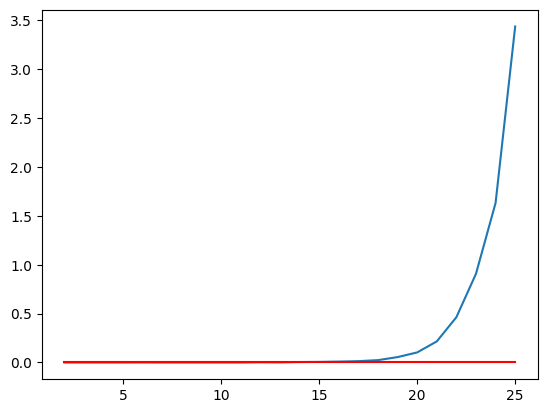

In [ ]:
plt.plot(np.arange(2,26), time1)
plt.plot(np.arange(2,26), time2, color = 'red')

As can be seen, the first algorithm has an higher running time than the second for bigger values of n and his exponential trend seems to be confirmed. On the other hand, the second solution has a polynomial complexity, but in the range [2,25] of n, for my pc the running time is always 0.0.  

## 5. (Optional, mini bonus) Is the algorithm of question 3 optimal? If you belive it, can you prove it? If not, can you find a faster algorithm? In case you found a faster algorithm implement it and explain your algorithm in detail. ##

In [ ]:
def cut_three(n):
    if n <= 1:
        return 0
    elif n == 2:
        return 1
    elif n == 3:
        return 2
    prod = 1
    while n > 4:
        n = n - 3
        prod = prod * 3
    prod = prod * n
    return prod


In [ ]:
cut_three(4)

4

In [ ]:
cut_two(4)

4

There is a pattern that can be recognised,the maximum product among the length of the cuts, is calculated repeatedly cutting parts of length 3 while length is greater than 4. The size 0 and 1 are managed by the first if, the size 2 by the second and the size 3 by the third. Moreover, the size 4 is managed with only the use of prod = prod*n(where n is equal to 4 and prod is equal to 1).